<a href="https://colab.research.google.com/github/ZackAkil/stateful-object-tracking/blob/main/player_detection_v1_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/ZackAkil/stateful-object-tracking/raw/main/v1_15/400_700_1_v1_13.h5

--2023-05-31 18:35:49--  https://github.com/ZackAkil/stateful-object-tracking/raw/main/v1_15/400_700_1_v1_13.h5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/v1_15/400_700_1_v1_13.h5 [following]
--2023-05-31 18:35:49--  https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/v1_15/400_700_1_v1_13.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626104 (611K) [application/octet-stream]
Saving to: ‘400_700_1_v1_13.h5’

400_700_1_v1_13.h5  100%[===================>] 611.43K  --.-KB/s    in 0.05s   

2023-05-31 18:35:49 (12.9 MB/s) - ‘400_7

In [2]:
from tensorflow import keras

# Load the saved model
model = keras.models.load_model("400_700_1_v1_13.h5")

In [4]:
import numpy as np

In [16]:
test_input = np.random.random([1, 400, 700, 3])
test_input.shape

(1, 400, 700, 3)

In [17]:
prediction = model.predict(test_input)

1/1 [==============================] - 0s 454ms/step


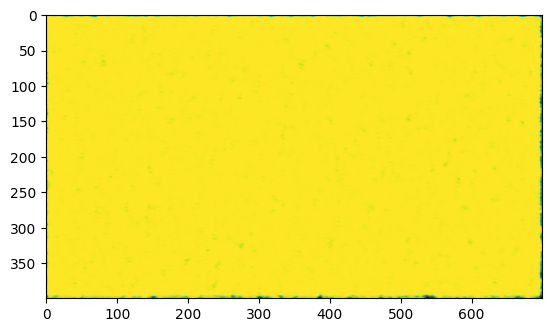

In [20]:
import matplotlib.pyplot as plt

plt.imshow(prediction[0])

In [58]:
import numpy as np
from scipy.ndimage import binary_dilation

def expand_islands(matrix, n=1):
    # Create a structuring element for dilation
    structure = np.ones((3, 3), dtype=int)

    # Perform binary dilation on the matrix
    dilated_matrix = binary_dilation(matrix, iterations=n)

    return dilated_matrix


from scipy.ndimage import label, sum

def remove_small_islands(matrix, n=100):
    labeled_matrix, num_features = label(matrix)  # Label connected components
    component_sizes = sum(matrix, labeled_matrix, range(num_features + 1))  # Calculate sizes

    # Create a mask to filter out small islands
    # print(component_sizes)
    mask = (component_sizes >= n)

    # Apply the mask to remove small islands
    filtered_matrix = mask[labeled_matrix]

    return filtered_matrix


from scipy.ndimage import label

def find_islands(matrix):

  # Apply the label function to find connected components
  labeled_matrix, num_labels = label(matrix)

  # Get the unique labels
  unique_labels = np.unique(labeled_matrix)

  boxes = []
  # Iterate over the unique labels (excluding background label 0)
  for label_value in unique_labels[1:]:
      # Create a mask for the current label
      mask = (labeled_matrix == label_value)
      
      # Find the indices of the ones in the mask
      indices = np.where(mask)

      avg_y = indices[0].mean()
      avg_x = indices[1].mean()

      min_x = indices[1].min()
      max_x = indices[1].max()

      min_y = indices[0].min()
      max_y = indices[0].max()

      box = {'pos':{'x':avg_x, 'y':avg_y}, 'bbox':{'min_x':min_x, 'max_x':max_x,
                                                   'min_y':min_y, 'max_y':max_y}}
      boxes.append(box)

  return boxes

def run_box_huristic(mask):

  porlarized_matrix = mask > 0.5

  expanded_pixels = expand_islands(porlarized_matrix, 1)

  removed_small_islands = remove_small_islands(expanded_pixels, n=50)

  boxes = find_islands(removed_small_islands)

  return boxes


In [22]:
!wget https://github.com/ZackAkil/stateful-object-tracking/raw/main/training_data/drone_45.mp4

--2023-05-31 19:30:15--  https://github.com/ZackAkil/stateful-object-tracking/raw/main/training_data/drone_45.mp4
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/training_data/drone_45.mp4 [following]
--2023-05-31 19:30:15--  https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/training_data/drone_45.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25046252 (24M) [application/octet-stream]
Saving to: ‘drone_45.mp4’

drone_45.mp4        100%[===================>]  23.89M   154MB/s    in 0.2s    

2023-05-31 19:30:16 (154 MB/s) - ‘drone

In [23]:
import cv2

# Path to the video file
video_path = 'drone_45.mp4'

# Open the video file
video = cv2.VideoCapture(video_path)


In [24]:
ret, frame = video.read()

In [29]:

frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


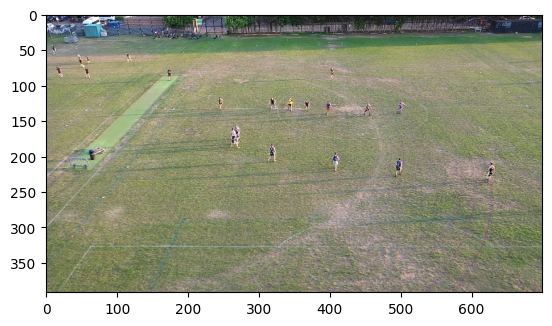

In [30]:
plt.imshow(frame_np)

In [31]:
# Resize the image to the desired dimensions
resized_image = cv2.resize(frame_np, (700, 400))

# Normalize and convert to numpy array
resized_image = resized_image / 255.0
resized_image = np.expand_dims(resized_image, axis=0)

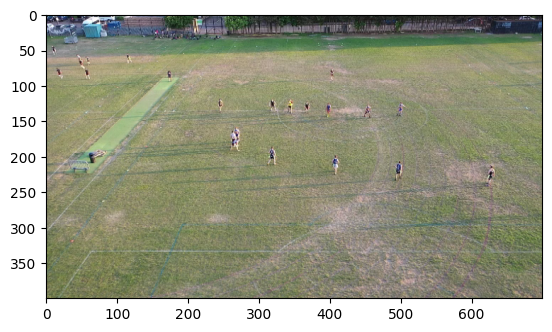

In [33]:
plt.imshow(resized_image[0])

In [34]:
prediction = model.predict(resized_image)

1/1 [==============================] - 1s 608ms/step


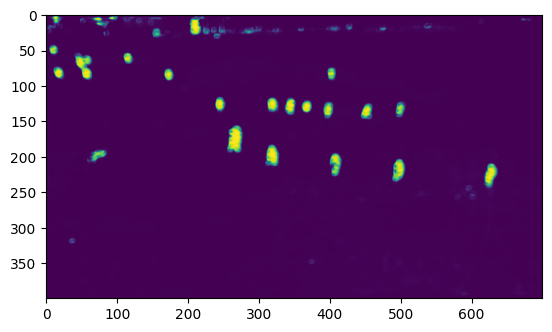

In [42]:
plt.imshow(prediction[0])

In [62]:
def plot_boxes(image, bboxes, save=None):

  # plt.imshow(labeled_matrix)
  plt.clf()
  plt.imshow(image)

  # Set the plot aspect ratio to equal
  plt.gca().set_aspect('equal')

  # Iterate over the unique labels (excluding background label 0)
  for box in bboxes:

      avg_y = box['pos']['y']
      avg_x = box['pos']['x']

      min_x = box['bbox']['min_x']
      max_x = box['bbox']['max_x']

      min_y = box['bbox']['min_y']
      max_y = box['bbox']['max_y']

      x, y = avg_x, avg_y
      circle = plt.Circle((x, y), radius=2, color='red', fill=True)

      rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                         linewidth=1, edgecolor='r', facecolor='none')
      plt.gca().add_patch(circle)
      plt.gca().add_patch(rect)
      plt.axis('off')
  if save:
    plt.savefig(f'{save}.png', bbox_inches='tight', pad_inches=0)
  else:
    plt.show()
  

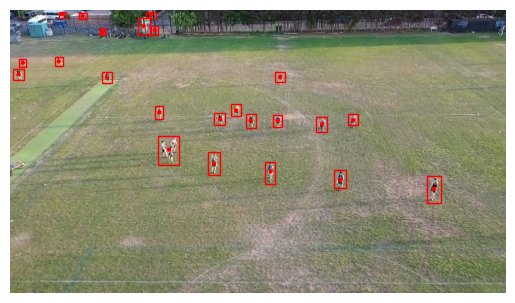

In [63]:
prediction_boxes = run_box_huristic(prediction[0])

plot_boxes(resized_image[0], prediction_boxes, save="1") 

625
626
627
628
629
630
1/1 [==============================] - 15s 15s/step
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
1/1 [==============================] - 13s 13s/step
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
1/1 [==============================] - 13s 13s/step
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
1/1 [==============================] - 13s 13s/step
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
1/1 [==============================] - 14s 14s/step
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
1/1 [==============================] - 13s 13s/step
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796


IndexError: ignored

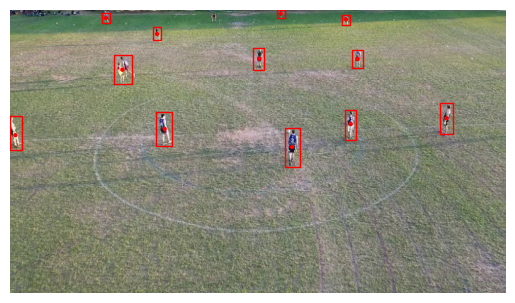

In [64]:
# Path to the video file
video_path = 'drone_45.mp4'

# Open the video file
video = cv2.VideoCapture(video_path)
index = 0

batch = 30

while True:

    images = []
    for i in range(batch):

      # Read the next frame
      success, frame = video.read()
      # Check if frame reading was successful
      if not success:
          break
      frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      # Resize the image to the desired dimensions
      resized_image = cv2.resize(frame_np, (700, 400))
      images.append(resized_image)
    
    resized_images = np.array(images)
    # Normalize and convert to numpy array
    resized_image = resized_images / 255.0
    # resized_image = np.expand_dims(resized_image, axis=0)
    prediction = model.predict(resized_image)

    for i in range(batch):

      prediction_boxes = run_box_huristic(prediction[i])
      index += 1
      plot_boxes(resized_images[i], prediction_boxes, save=f'predictions/{index}') 
      print(index)
    

In [72]:
!ffmpeg -framerate 10 -i predictions/1%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -crf 23 -pix_fmt yuv420p output1.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [76]:
import cv2
import os

# Path to the folder containing the images
folder_path = 'predictions'

# Get a list of all image files in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Specify the output video settings
output_video_path = 'output_video.mp4'
fps = 25.0  # Frames per second
frame_size = (496,283)  # Specify the frame size (width, height)

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the video codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

# Iterate over each image file and write it to the video

for i in range(1000):
    image_path = f'predictions/{i}.png'
    frame = cv2.imread(image_path)
    out.write(frame)

# Release the VideoWriter
out.release()


In [73]:
!zip -r output.zip predictions

  adding: predictions/ (stored 0%)
  adding: predictions/1075.png (deflated 0%)
  adding: predictions/1132.png (deflated 0%)
  adding: predictions/1130.png (deflated 0%)
  adding: predictions/52.png (deflated 0%)
  adding: predictions/734.png (deflated 0%)
  adding: predictions/368.png (deflated 0%)
  adding: predictions/898.png (deflated 0%)
  adding: predictions/22.png (deflated 0%)
  adding: predictions/907.png (deflated 0%)
  adding: predictions/1123.png (deflated 0%)
  adding: predictions/129.png (deflated 0%)
  adding: predictions/224.png (deflated 0%)
  adding: predictions/402.png (deflated 0%)
  adding: predictions/391.png (deflated 0%)
  adding: predictions/49.png (deflated 0%)
  adding: predictions/397.png (deflated 0%)
  adding: predictions/474.png (deflated 0%)
  adding: predictions/779.png (deflated 0%)
  adding: predictions/916.png (deflated 0%)
  adding: predictions/333.png (deflated 0%)
  adding: predictions/435.png (deflated 0%)
  adding: predictions/689.png (deflated 